In [1]:
%matplotlib inline
import pandas as pd
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from lob_data_utils.roc_results import results_15000 as results
from lob_data_utils import lob
from lob_data_utils import db_result

In [2]:
result = db_result.get_svm_results_for_data_length(15000, 'cv')

df = pd.DataFrame(result)
df.head()

,algorithm_id,c,coef0,data_length,data_type,gamma,id,kernel,name,roc_auc_score,stock,svm_id
0,57,0.0001,0.0000,15000,cv,0.0001,58,sigmoid,svm-sigmoid,0.5,9069,58
1,58,0.0001,0.0001,15000,cv,0.0001,59,sigmoid,svm-sigmoid,0.5,9069,59
2,59,0.0001,0.0010,15000,cv,0.0001,60,sigmoid,svm-sigmoid,0.5,9069,60
3,60,0.0001,1.0000,15000,cv,0.0001,61,sigmoid,svm-sigmoid,0.5,9069,61
4,61,0.0001,10.0000,15000,cv,0.0001,62,sigmoid,svm-sigmoid,0.5,9069,62


In [3]:
print(len(df))
df.drop('algorithm_id', axis=1, inplace=True)
df.drop('svm_id', axis=1, inplace=True)
df.head()

7007


,c,coef0,data_length,data_type,gamma,id,kernel,name,roc_auc_score,stock
0,0.0001,0.0000,15000,cv,0.0001,58,sigmoid,svm-sigmoid,0.5,9069
1,0.0001,0.0001,15000,cv,0.0001,59,sigmoid,svm-sigmoid,0.5,9069
2,0.0001,0.0010,15000,cv,0.0001,60,sigmoid,svm-sigmoid,0.5,9069
3,0.0001,1.0000,15000,cv,0.0001,61,sigmoid,svm-sigmoid,0.5,9069
4,0.0001,10.0000,15000,cv,0.0001,62,sigmoid,svm-sigmoid,0.5,9069


In [4]:
log_res = []
for i, row in df.iterrows():
    log_res.append(results.get(row['stock']))
df['log_res'] = log_res
df['diff'] = df['roc_auc_score'] - log_res

In [5]:
print(len(df['stock'].unique()))
print(len(df[df['log_res'] < df['roc_auc_score']]['stock'].unique()))

13
12


In [6]:
bests = []
df_best_agg = df.groupby('stock', as_index=False)['roc_auc_score'].idxmax()
df_bests = df.loc[df_best_agg]
df_bests.index = df_bests['stock']

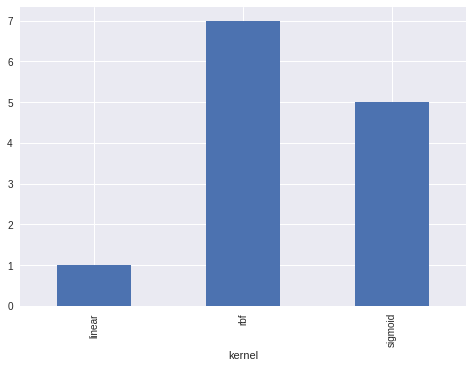

In [7]:
df_bests.groupby('kernel')['kernel'].count().plot(kind='bar')

In [8]:
df_bests.groupby(['kernel', 'stock'])['kernel'].unique()

kernel   stock
linear   9062      [linear]
rbf      11244        [rbf]
         12059        [rbf]
         9058         [rbf]
         9064         [rbf]
         9067         [rbf]
         9069         [rbf]
         9094         [rbf]
sigmoid  10166    [sigmoid]
         9061     [sigmoid]
         9063     [sigmoid]
         9265     [sigmoid]
         9269     [sigmoid]
Name: kernel, dtype: object

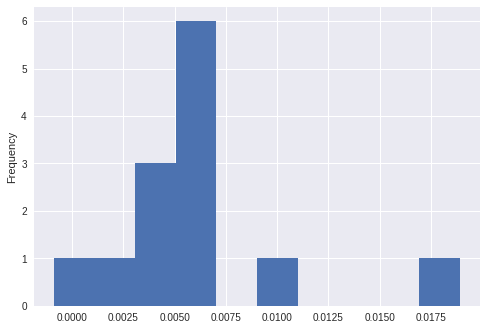

In [9]:
df_bests['diff'].plot(kind='hist')

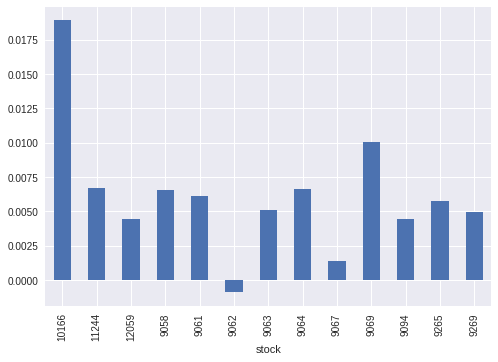

In [10]:
df_bests['diff'].plot(kind='bar')

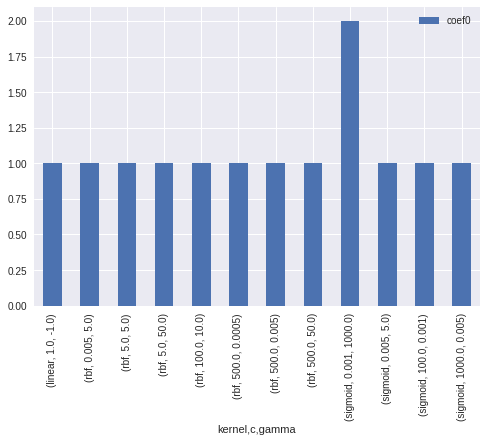

In [11]:
df_bests.groupby(['kernel', 'c', 'gamma'])[['coef0']].count().plot(kind='bar')

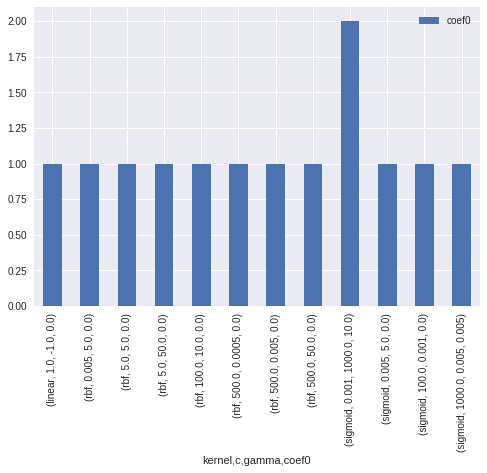

In [12]:
df_bests.groupby(['kernel', 'c', 'gamma', 'coef0'])[['coef0']].count().plot(kind='bar')

In [13]:
print(df_bests[df_bests['kernel'] == 'rbf']['diff'].median())
print(df_bests[df_bests['kernel'] == 'sigmoid']['diff'].median())
print(df_bests[df_bests['kernel'] == 'linear']['diff'].median())

0.006540299696321306
0.005726307948116016
-0.000876676407515431


In [14]:
print(df_bests[df_bests['kernel'] == 'rbf']['diff'].std())
print(df_bests[df_bests['kernel'] == 'sigmoid']['diff'].std())
print(df_bests[df_bests['kernel'] == 'linear']['diff'].std())

0.0026743220071375326
0.006032448579070596
nan


In [15]:
print(df_bests[df_bests['kernel'] == 'rbf']['diff'].mean())
print(df_bests[df_bests['kernel'] == 'sigmoid']['diff'].mean())
print(df_bests[df_bests['kernel'] == 'linear']['diff'].mean())

0.005740349849713421
0.00815562728745307
-0.000876676407515431


In [16]:
print(df_bests[df_bests['kernel'] == 'rbf'][df_bests['diff'] < 0]['diff'].mean())
print(df_bests[df_bests['kernel'] == 'sigmoid'][df_bests['diff'] < 0]['diff'].mean())
print(df_bests[df_bests['kernel'] == 'linear'][df_bests['diff'] < 0]['diff'].mean())

nan
nan
-0.000876676407515431


In [17]:
print(df_bests[df_bests['kernel'] == 'rbf'][df_bests['diff'] < 0]['diff'].min())
print(df_bests[df_bests['kernel'] == 'sigmoid'][df_bests['diff'] < 0]['diff'].min())
print(df_bests[df_bests['kernel'] == 'linear'][df_bests['diff'] < 0]['diff'].min())

nan
nan
-0.000876676407515


In [18]:
df_roc = pd.DataFrame()
df_roc['stock'] = results.keys()
df_roc['roc_area'] = results.values()

df_roc = df_roc.sort_values(by='roc_area', ascending=False)

dfs = {}
dfs_test = {}
dfs_cv = {}
stocks = df_bests.index  #df_roc['stock'].values

for s in stocks:
    d, d_cv, d_test = lob.load_prepared_data(
        s, cv=True, data_dir='../data/prepared/', length=15000)
    if not np.any(d):
        continue
    dfs[s] = d
    dfs_cv[s] = d_cv
    dfs_test[s] = d_test
stocks = list(dfs.keys())

In [19]:
df_roc = pd.DataFrame()
df_roc['stock'] = [s for s in results.keys() if s in stocks]
df_roc['roc_area'] = [results[s] for s in results.keys() if s in stocks]
df_roc = df_roc.sort_values(by='roc_area', ascending=False)
df_roc.head()

,stock,roc_area
2,9094,0.564523
8,9067,0.561571
4,9061,0.550878
1,9063,0.550200
9,9265,0.549511


In [66]:
df_summary = pd.DataFrame(index=stocks)
sum_sell_ask_mean = []
sum_buy_bid_mean = []
max_trade_price = []
min_trade_price = []
bid_ask_spread = []
bid_len = []
ask_len = []
sum_len_ask = []
sum_len_bid = []
mean_queue_imb = []

for s in stocks:
    sum_sell_ask_mean.append(dfs[s]['sum_sell_ask'].mean())
    sum_buy_bid_mean.append(dfs[s]['sum_buy_bid'].mean())
    max_trade_price.append(max( dfs[s]['bid_price'].max(), dfs[s]['ask_price'].max()))
    min_trade_price.append(max( dfs[s]['bid_price'].min(), dfs[s]['ask_price'].min()))
    bid_ask_spread.append((dfs[s]['ask_price'] - dfs[s]['bid_price']).mean())
    max_len_bid = 0
    max_len_ask = 0
    sum_bid = 0
    sum_ask = 0
    for i, row in dfs[s].iterrows():
        sum_bid += len(row['bid'])
        sum_ask += len(row['ask'])
        if len(row['bid']) > max_len_bid:
            max_len_bid = len(row['bid'])
        if len(row['ask']) > max_len_ask:
            max_len_ask = len(row['ask'])
    bid_len.append(max_len_bid)
    ask_len.append(max_len_ask)
    sum_len_ask.append(sum_bid / len(dfs[s]))
    sum_len_bid.append(sum_ask / len(dfs[s]))
    mean_queue_imb.append(dfs[s]['queue_imbalance'].std())
df_summary['roc_area'] = df_roc['roc_area'].values
df_summary['sum_sell_ask_mean'] = sum_sell_ask_mean
df_summary['sum_buy_bid_mean'] = sum_buy_bid_mean
df_summary['diff_mean_bid_ask'] = df_summary['sum_sell_ask_mean'] - df_summary['sum_buy_bid_mean']
df_summary['max_trade_price'] = max_trade_price
df_summary['min_trade_price'] = min_trade_price
df_summary['diff_trade_price'] = df_summary['max_trade_price'] - df_summary['min_trade_price']
df_summary['bid_ask_spread'] = bid_ask_spread
df_summary['len_ask'] = ask_len
df_summary['len_bid'] = bid_len
df_summary['mean_len_ask'] = sum_len_ask
df_summary['mean_len_bid'] = sum_len_bid
df_summary['mean_sum_len_ask_bid'] = (np.array(sum_len_ask) + np.array(sum_len_bid)) / 2
df_summary['mean_queue_imb'] = (df_summary['diff_trade_price'] + df_summary['bid_ask_spread']) / (mean_queue_imb)

df_summary.sort_values(by='bid_ask_spread')[df_summary['roc_area'] >= 0.58].head()


,roc_area,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,len_ask,len_bid,mean_len_ask,mean_len_bid,mean_sum_len_ask_bid,mean_queue_imb


In [67]:
df_bests.sort_index(inplace=True)
df_summary.sort_index(inplace=True)
df_all = df_bests.join(df_summary)
diff_ind = []
for i, r in df_bests.iterrows():
    if r['diff'] <= 0:
        diff_ind.append(0)
    else:
        diff_ind.append(1)
df_all['diff_ind'] = diff_ind

In [68]:
df_all.head()

,c,coef0,data_length,data_type,gamma,id,kernel,name,roc_auc_score,stock,...,min_trade_price,diff_trade_price,bid_ask_spread,len_ask,len_bid,mean_len_ask,mean_len_bid,mean_sum_len_ask_bid,mean_queue_imb,diff_ind
stock,,,,,,,,,,,,,,,,,,,,,
10166,0.001,10.0,15000,cv,1000.000,139,sigmoid,svm-sigmoid,0.563167,10166,...,2965.0,489.5,1.216444,1222,1446,949.992111,841.328444,895.660278,954.552408,1
11244,500.000,0.0,15000,cv,50.000,537,rbf,svm-sigmoid,0.538229,11244,...,324.3,31.2,0.115528,3028,2576,1956.802667,2506.891222,2231.846944,59.189330,1
12059,500.000,0.0,15000,cv,0.005,521,rbf,svm-sigmoid,0.534971,12059,...,350.5,40.8,0.225400,1696,2032,1393.319556,1179.239667,1286.279611,77.123223,1
9058,100.000,0.0,15000,cv,10.000,49,rbf,svm-sigmoid,0.550972,9058,...,1764.0,235.0,0.785167,1916,1920,1364.049111,1488.813778,1426.431444,448.105227,1
9061,0.005,0.0,15000,cv,5.000,375,sigmoid,svm-sigmoid,0.556986,9061,...,662.3,67.9,0.174156,2271,1823,1297.906333,1656.132778,1477.019556,127.129820,1


In [69]:
df_summary.head()

,roc_area,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,len_ask,len_bid,mean_len_ask,mean_len_bid,mean_sum_len_ask_bid,mean_queue_imb
10166,0.564523,772.453000,840.732222,-68.279222,3454.5,2965.0,489.5,1.216444,1222,1446,949.992111,841.328444,895.660278,954.552408
11244,0.561571,3947.334556,4092.047333,-144.712778,355.5,324.3,31.2,0.115528,3028,2576,1956.802667,2506.891222,2231.846944,59.189330
12059,0.550878,5667.953333,5446.236778,221.716556,391.3,350.5,40.8,0.225400,1696,2032,1393.319556,1179.239667,1286.279611,77.123223
9058,0.550200,2979.733000,3185.756556,-206.023556,1999.0,1764.0,235.0,0.785167,1916,1920,1364.049111,1488.813778,1426.431444,448.105227
9061,0.549511,6452.364000,6757.769556,-305.405556,730.2,662.3,67.9,0.174156,2271,1823,1297.906333,1656.132778,1477.019556,127.129820


In [70]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(["sigmoid", "linear", "rbf"])
df_all['kernel_class'] = le.transform(df_all['kernel'])
df_all.head()

,c,coef0,data_length,data_type,gamma,id,kernel,name,roc_auc_score,stock,...,diff_trade_price,bid_ask_spread,len_ask,len_bid,mean_len_ask,mean_len_bid,mean_sum_len_ask_bid,mean_queue_imb,diff_ind,kernel_class
stock,,,,,,,,,,,,,,,,,,,,,
10166,0.001,10.0,15000,cv,1000.000,139,sigmoid,svm-sigmoid,0.563167,10166,...,489.5,1.216444,1222,1446,949.992111,841.328444,895.660278,954.552408,1,2
11244,500.000,0.0,15000,cv,50.000,537,rbf,svm-sigmoid,0.538229,11244,...,31.2,0.115528,3028,2576,1956.802667,2506.891222,2231.846944,59.189330,1,1
12059,500.000,0.0,15000,cv,0.005,521,rbf,svm-sigmoid,0.534971,12059,...,40.8,0.225400,1696,2032,1393.319556,1179.239667,1286.279611,77.123223,1,1
9058,100.000,0.0,15000,cv,10.000,49,rbf,svm-sigmoid,0.550972,9058,...,235.0,0.785167,1916,1920,1364.049111,1488.813778,1426.431444,448.105227,1,1
9061,0.005,0.0,15000,cv,5.000,375,sigmoid,svm-sigmoid,0.556986,9061,...,67.9,0.174156,2271,1823,1297.906333,1656.132778,1477.019556,127.129820,1,2


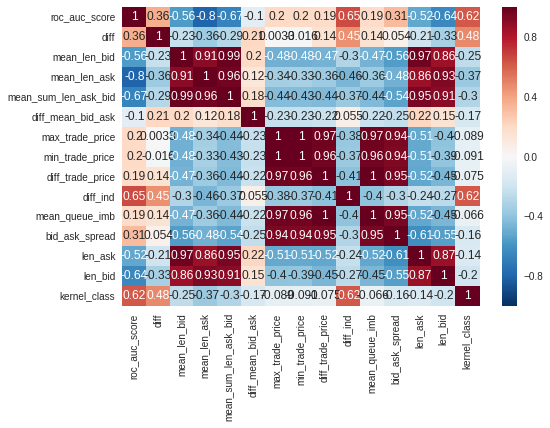

In [72]:
features = ['roc_auc_score', 'diff', 'mean_len_bid', 'mean_len_ask', 'mean_sum_len_ask_bid',
            'diff_mean_bid_ask', 'max_trade_price', 'min_trade_price',
            'diff_trade_price', 'diff_ind', 'mean_queue_imb',
            'bid_ask_spread', 'len_ask', 'len_bid', 'kernel_class']
# TODO: maybe some metric of queue_imbalance!
sns.heatmap(df_all[features].corr(), annot=True)

## Clustering

In [73]:
data_lens = []
for s in df_all.index:
    data_lens.append(len(dfs[s]))
df_all['data_len'] = data_lens
df_all.head()

,c,coef0,data_length,data_type,gamma,id,kernel,name,roc_auc_score,stock,...,bid_ask_spread,len_ask,len_bid,mean_len_ask,mean_len_bid,mean_sum_len_ask_bid,mean_queue_imb,diff_ind,kernel_class,data_len
stock,,,,,,,,,,,,,,,,,,,,,
10166,0.001,10.0,15000,cv,1000.000,139,sigmoid,svm-sigmoid,0.563167,10166,...,1.216444,1222,1446,949.992111,841.328444,895.660278,954.552408,1,2,9000
11244,500.000,0.0,15000,cv,50.000,537,rbf,svm-sigmoid,0.538229,11244,...,0.115528,3028,2576,1956.802667,2506.891222,2231.846944,59.189330,1,1,9000
12059,500.000,0.0,15000,cv,0.005,521,rbf,svm-sigmoid,0.534971,12059,...,0.225400,1696,2032,1393.319556,1179.239667,1286.279611,77.123223,1,1,9000
9058,100.000,0.0,15000,cv,10.000,49,rbf,svm-sigmoid,0.550972,9058,...,0.785167,1916,1920,1364.049111,1488.813778,1426.431444,448.105227,1,1,9000
9061,0.005,0.0,15000,cv,5.000,375,sigmoid,svm-sigmoid,0.556986,9061,...,0.174156,2271,1823,1297.906333,1656.132778,1477.019556,127.129820,1,2,9000


In [79]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
a_features = ['len_bid', 'len_ask', 'bid_ask_spread', 'sum_len_bid', 'sum_len_ask',
            'max_trade_price', 'min_trade_price', 'sum_sell_ask_mean',
           'sum_buy_bid_mean', 'mean_queue_imb']

features = ['mean_sum_len_ask_bid']

X = df_all[features]

kmeans = KMeans(n_clusters=3, random_state=0).fit_predict(X)
df_all['del'] = kmeans

In [83]:
df_all[['del', 'roc_auc_score', 'kernel', 
        'mean_len_bid', 'mean_sum_len_ask_bid']].sort_values(by='mean_sum_len_ask_bid')

,del,roc_auc_score,kernel,mean_len_bid,mean_sum_len_ask_bid
stock,,,,,
10166,2,0.563167,sigmoid,841.328444,895.660278
9067,2,0.562984,rbf,851.610333,962.915667
9094,2,0.568948,rbf,1156.725333,1053.530500
9265,0,0.555238,sigmoid,1155.430778,1216.601222
12059,0,0.534971,rbf,1179.239667,1286.279611
9269,0,0.552233,sigmoid,1314.719444,1328.736944
9064,0,0.542943,rbf,1512.713444,1421.505500
9058,0,0.550972,rbf,1488.813778,1426.431444
9061,0,0.556986,sigmoid,1656.132778,1477.019556


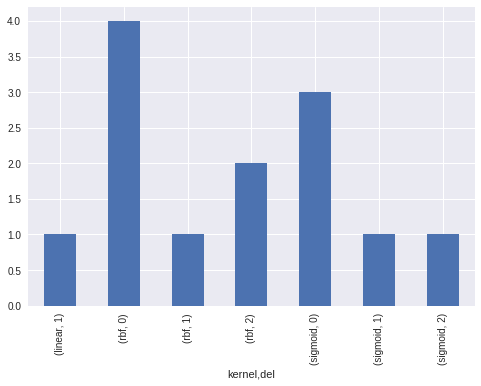

In [82]:
df_all.groupby(['kernel', 'del'])['del'].count().plot(kind='bar')

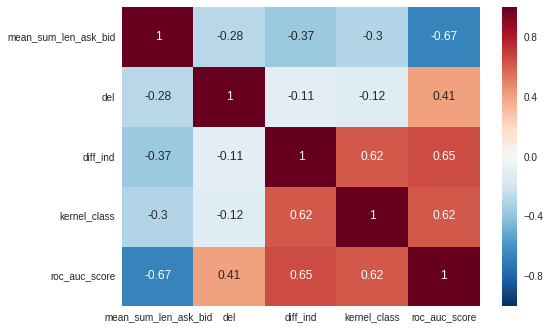

In [84]:

sns.heatmap(df_all[features + ['del', 'diff_ind', 'kernel_class', 'roc_auc_score' ]].corr(), 
            annot=True)

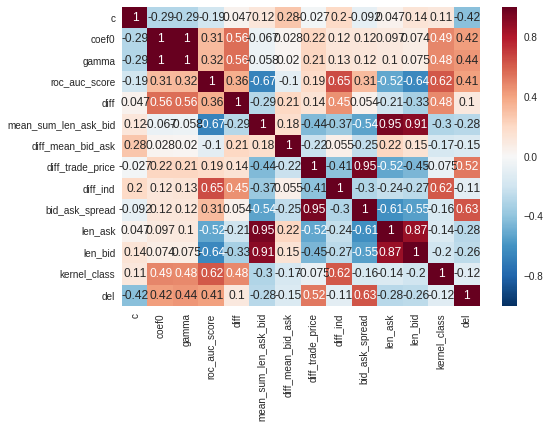

In [85]:
features = ['c', 'coef0', 'gamma', 'roc_auc_score', 'diff', 'mean_sum_len_ask_bid',
            'diff_mean_bid_ask', 'diff_trade_price', 'diff_ind',
            'bid_ask_spread', 'len_ask', 'len_bid', 'kernel_class', 'del']
sns.heatmap(df_all[features].corr(), annot=True)

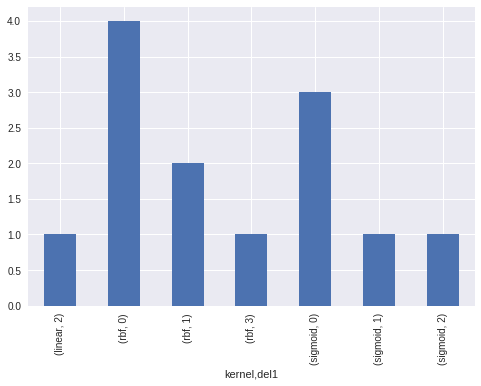

In [87]:
from sklearn.cluster import SpectralClustering, MeanShift, AffinityPropagation 
from sklearn.decomposition import PCA
a_features = ['len_bid', 'len_ask', 'bid_ask_spread',  'mean_queue_imb',
            'max_trade_price', 'min_trade_price', 'sum_sell_ask_mean',
           'sum_buy_bid_mean']
features = [ 'mean_sum_len_ask_bid']

X = df_all[features]

kmeans = MeanShift().fit_predict(X)
df_all['del1'] = kmeans
df_all.groupby(['kernel', 'del1'])['del1'].count().plot(kind='bar')

### Check bad ones

In [88]:
f = ['sum_sell_ask_mean', 'sum_buy_bid_mean',
       'diff_mean_bid_ask', 'max_trade_price', 'min_trade_price',
       'diff_trade_price', 'bid_ask_spread',
       'len_ask', 'len_bid', 'data_len']
worst_row = df_all[f][df_all['diff'] < 0]
worst_stocks = worst_row.index
worst_row

,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,len_ask,len_bid,data_len
stock,,,,,,,,,,
9062,990.060111,996.598667,-6.538556,3351.0,2937.0,414.0,0.999056,2517,2258,9000


In [89]:
df_all[f].describe()

,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,len_ask,len_bid,data_len
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.0
mean,6318.882692,6162.493966,156.388726,1553.534615,1371.803846,181.730769,0.527553,2027.230769,1929.307692,9000.0
std,7621.612550,7356.768655,893.739247,1420.234640,1254.646666,171.100805,0.469723,615.183191,366.230434,0.0
min,772.453000,840.732222,-552.276444,79.850000,72.700000,7.150000,0.025367,1206.000000,1324.000000,9000.0
25%,1238.612444,1337.303556,-206.023556,391.300000,343.000000,40.950000,0.108339,1676.000000,1739.000000,9000.0
50%,3947.334556,4092.047333,-82.659222,730.200000,662.300000,67.900000,0.225400,1916.000000,1903.000000,9000.0
75%,6452.364000,6757.769556,12.568333,3351.000000,2937.000000,307.500000,0.999056,2329.000000,2032.000000,9000.0
max,27371.843222,27615.118889,3010.993667,3549.000000,3163.500000,489.500000,1.216444,3101.000000,2576.000000,9000.0


In [90]:
list(df_bests[df_bests['diff'] < 0.005]['stock'])

['12059', '9062', '9067', '9094', '9269']

In [91]:
df_bests['diff'].mean()

0.006160300690595682

In [92]:
df_bests['diff'].median()

0.005726307948116016

In [93]:
df_bests['diff'].std()

0.004646987656939358

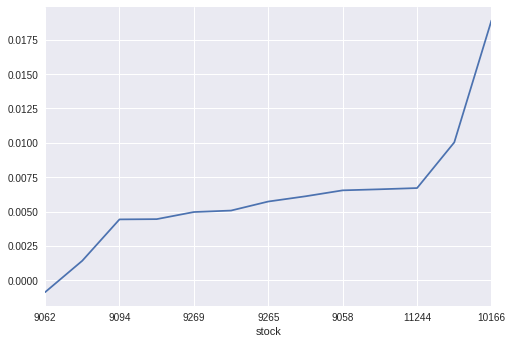

In [94]:
df_bests['diff'].sort_values().plot()

### 10484

In [95]:
print(worst_stocks)
if not np.any(worst_stocks):
    worst_stocks = list(df_bests[df_bests['diff'] < 0.002]['stock'])

Index(['9062'], dtype='object', name='stock')


[]

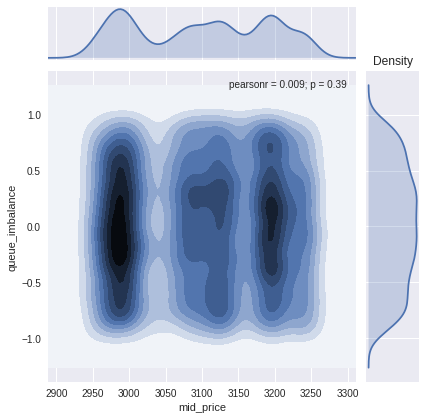

In [96]:
s = worst_stocks[0]
sns.jointplot(x="mid_price", y="queue_imbalance", data=dfs[s].loc[:, ['mid_price', 'queue_imbalance']], kind="kde")
plt.title('Density')
plt.plot()

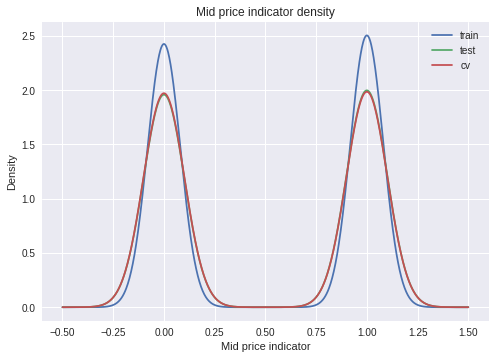

In [41]:
s = worst_stocks[0]
dfs[s]['mid_price_indicator'].plot('kde', label='train')
dfs_test[s]['mid_price_indicator'].plot('kde', label='test')
dfs_cv[s]['mid_price_indicator'].plot('kde', label='cv')
plt.legend()
plt.xlabel('Mid price indicator')
plt.title('Mid price indicator density')

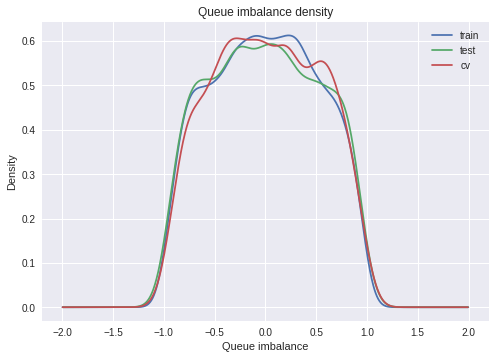

In [42]:
s = worst_stocks[0]

dfs[s]['queue_imbalance'].plot('kde', label='train')
dfs_test[s]['queue_imbalance'].plot('kde', label='test')
dfs_cv[s]['queue_imbalance'].plot('kde', label='cv')
plt.legend()
plt.xlabel('Queue imbalance')
plt.title('Queue imbalance density')

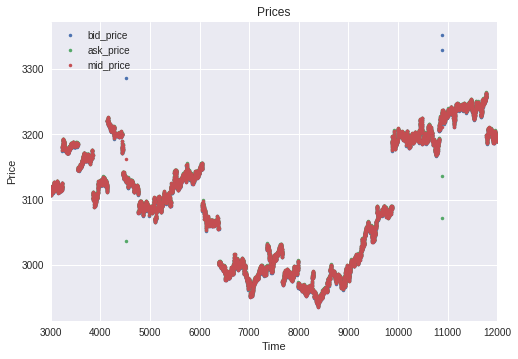

In [43]:
dfs[s][['bid_price', 'ask_price', 'mid_price']].plot(style='.')
plt.legend()
plt.title('Prices')
plt.xlabel('Time')
plt.ylabel('Price')

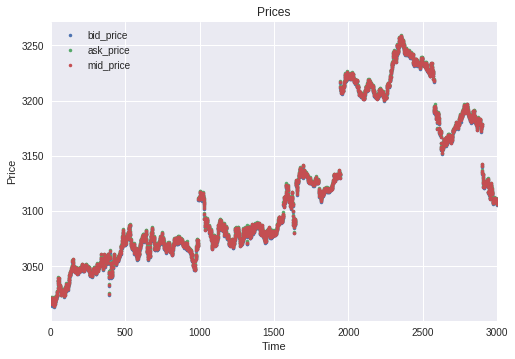

In [44]:
dfs_test[s][['bid_price', 'ask_price', 'mid_price']].plot(style='.')
plt.legend()
plt.title('Prices')
plt.xlabel('Time')
plt.ylabel('Price')

In [45]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import norm
# from sklearn.neighbors import KernelDensity
# s = worst_stocks[0]
# X = dfs[s]['queue_imbalance'].reshape(-1, 1)
# kde = KernelDensity(kernel='gaussian').fit(X)
# log_dens = kde.score_samples(X)
# print(log_dens)
# plt.scatter(dfs[s].index, np.exp(log_dens))
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# x =  dfs[s]['queue_imbalance'].values
# y = dfs[s]['mid_price_indicator'].values

#x, y = np.meshgrid(np.exp(log_dens), dfs[s]['queue_imbalance'].values)

#ax.plot_surface(x, y, dfs[s].index)


In [46]:
best_stocks = list(df_bests[df_bests['diff'] > 0.015]['stock'])
best_stocks

['10166']

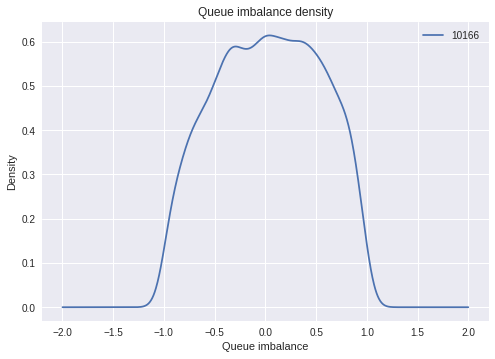

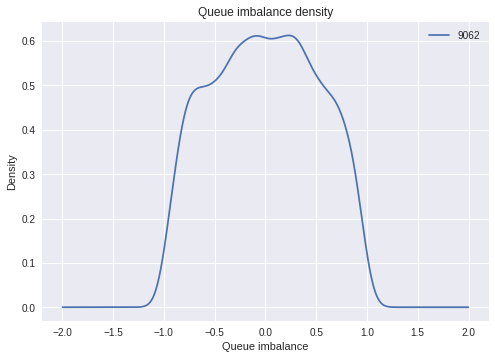

In [47]:
for s in best_stocks:
    dfs[s]['queue_imbalance'].plot('kde', label=s)
    plt.legend()
    plt.xlabel('Queue imbalance')
plt.title('Queue imbalance density')
plt.figure()

for s in worst_stocks:
    dfs[s]['queue_imbalance'].plot('kde', label=s)
    plt.legend()
    plt.xlabel('Queue imbalance')
plt.title('Queue imbalance density')

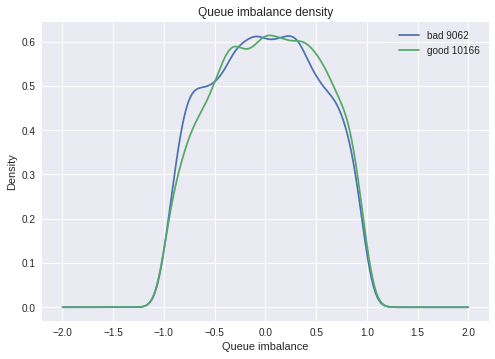

In [48]:
for s1, s2 in zip(best_stocks, worst_stocks):
    dfs[s2]['queue_imbalance'].plot('kde', label='bad ' + s2)
    dfs[s1]['queue_imbalance'].plot('kde', label='good ' + s1)
    plt.legend()
    plt.xlabel('Queue imbalance')
    plt.title('Queue imbalance density')
    plt.figure()

In [49]:
features = [ 'max_trade_price', 'diff', 'min_trade_price',
            'mean_queue_imb', 'len_ask', 'len_bid']
df_all[features][df_all['diff'] > 0.015]

,max_trade_price,diff,min_trade_price,mean_queue_imb,len_ask,len_bid
stock,,,,,,
10166,3454.5,0.018914,2965.0,954.552408,1222,1446


In [50]:
df_all[df_all['diff'] < 0.002][features]

,max_trade_price,diff,min_trade_price,mean_queue_imb,len_ask,len_bid
stock,,,,,,
9062,3351.0,-0.000877,2937.0,804.632318,2517,2258
9067,3417.0,0.001413,3109.5,597.230438,1206,1739


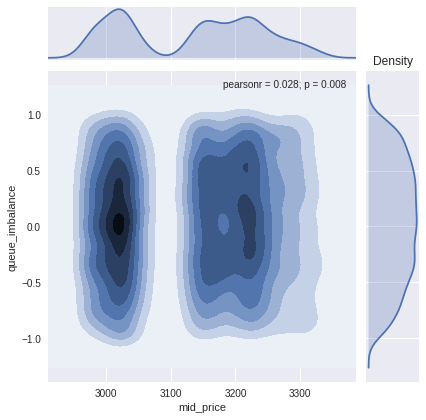

In [51]:
for s in best_stocks:
    sns.jointplot(x="mid_price", y="queue_imbalance", data=dfs[s].loc[:, ['mid_price', 'queue_imbalance']], kind="kde")
    plt.title('Density')
    plt.plot()
    plt.figure()

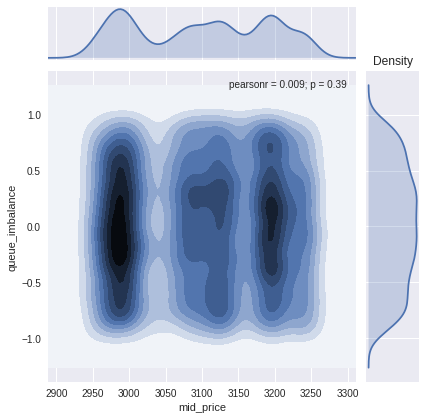

In [52]:
for s in worst_stocks:
    sns.jointplot(x="mid_price", y="queue_imbalance", data=dfs[s].loc[:, ['mid_price', 'queue_imbalance']], kind="kde")
    plt.title('Density')
    plt.plot()
    plt.figure()